<a href="https://colab.research.google.com/github/johnnyff/bigcontest2021/blob/main/danm_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import torch
import datetime as dt
import torch.nn as nn

warnings.filterwarnings(action='ignore') 

In [3]:
df = pd.read_excel('/content/drive/MyDrive/bigcontest/data/bigcontest_dataset.xlsx', header = 1)
df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,유역평균강수,강우(A지역),강우(B지역),강우(C지역),강우(D지역),수위(E지역),수위(D지역),유역평균강수.1,강우(A지역).1,강우(B지역).1,강우(C지역).1,강우(D지역).1,수위(E지역).1,수위(D지역).1,유역평균강수.2,강우(A지역).2,강우(B지역).2,강우(C지역).2,강우(D지역).2,수위(E지역).2,수위(D지역).2,유역평균강수.3,강우(A지역).3,강우(B지역).3,강우(C지역).3,강우(D지역).3,수위(E지역).3,수위(D지역).3,유역평균강수.4,강우(A지역).4,강우(B지역).4,강우(C지역).4,강우(D지역).4,수위(E지역).4,수위(D지역).4,유역평균강수.5,강우(A지역).5,강우(B지역).5,강우(C지역).5,강우(D지역).5,수위(E지역).5,수위(D지역).5
0,1,2006,7,10,8,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26,2018,7,7,17,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950
3047,26,2018,7,7,18,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.970
3048,26,2018,7,7,19,NaN,2.3689,1,0,0,0,3.13,130.01250,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,1,0,3.13,129.910714,2.3689,1,0,1,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.980
3049,26,2018,7,7,20,NaN,2.3689,1,0,0,0,3.11,130.01875,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,1,0,3.11,129.925000,2.3488,1,0,1,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.990


In [4]:
columns = ['num','year','month','day','hour','target',
           'average_rain_1','a_rain_1','b_rain_1','c_rain_1','d_rain_1','e_level_1','d_level_1',
           'average_rain_2','a_rain_2','b_rain_2','c_rain_2','d_rain_2','e_level_2','d_level_2',
           'average_rain_3','a_rain_3','b_rain_3','c_rain_3','d_rain_3','e_level_3','d_level_3',
           'average_rain_4','a_rain_4','b_rain_4','c_rain_4','d_rain_4','e_level_4','d_level_4',
           'average_rain_5','a_rain_5','b_rain_5','c_rain_5','d_rain_5','e_level_5','d_level_5',
           'average_rain_6','a_rain_6','b_rain_6','c_rain_6','d_rain_6','e_level_6','d_level_6'
           ]

In [5]:
df.columns =columns


In [6]:
df.drop(['year','month','day','hour'],axis =1 , inplace = True)
df

,num,target,average_rain_1,a_rain_1,b_rain_1,c_rain_1,d_rain_1,e_level_1,d_level_1,average_rain_2,a_rain_2,b_rain_2,c_rain_2,d_rain_2,e_level_2,d_level_2,average_rain_3,a_rain_3,b_rain_3,c_rain_3,d_rain_3,e_level_3,d_level_3,average_rain_4,a_rain_4,b_rain_4,c_rain_4,d_rain_4,e_level_4,d_level_4,average_rain_5,a_rain_5,b_rain_5,c_rain_5,d_rain_5,e_level_5,d_level_5,average_rain_6,a_rain_6,b_rain_6,c_rain_6,d_rain_6,e_level_6,d_level_6
0,1,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610
1,1,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600
2,1,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590
3,1,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585
4,1,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950
3047,26,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.970
3048,26,NaN,2.3689,1,0,0,0,3.13,130.01250,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,1,0,3.13,129.910714,2.3689,1,0,1,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.980
3049,26,NaN,2.3689,1,0,0,0,3.11,130.01875,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,1,0,3.11,129.925000,2.3488,1,0,1,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.990


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)
    print(torch.cuda.get_device_name(0))

Tesla K80


In [8]:
import torch
from torch.nn import Module, LSTM, Linear
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable

In [9]:
train_data = df[:-160]
train_data[train_data['num']==1]

,num,target,average_rain_1,a_rain_1,b_rain_1,c_rain_1,d_rain_1,e_level_1,d_level_1,average_rain_2,a_rain_2,b_rain_2,c_rain_2,d_rain_2,e_level_2,d_level_2,average_rain_3,a_rain_3,b_rain_3,c_rain_3,d_rain_3,e_level_3,d_level_3,average_rain_4,a_rain_4,b_rain_4,c_rain_4,d_rain_4,e_level_4,d_level_4,average_rain_5,a_rain_5,b_rain_5,c_rain_5,d_rain_5,e_level_5,d_level_5,average_rain_6,a_rain_6,b_rain_6,c_rain_6,d_rain_6,e_level_6,d_level_6
0,1,189.100000,6.4,7,7,7,8,2.54,122.56875,6.3,7,7,7,8,2.54,122.541667,6.3,7,7,7,8,2.54,122.550000,6.4,7,7,8,8,2.54,122.675000,6.4,7,7,8,8,2.54,122.660,6.4,7,7,8,8,2.54,122.610
1,1,216.951962,6.3,7,8,7,8,2.53,122.56250,6.4,7,8,7,8,2.53,122.550000,6.4,7,8,7,8,2.53,122.558333,7.3,7,8,10,10,2.53,122.667857,7.3,7,8,10,10,2.53,122.648,7.3,7,8,10,10,2.53,122.600
2,1,251.424419,6.4,7,9,7,8,2.53,122.55625,7.3,7,9,7,8,2.53,122.558333,7.3,7,9,8,8,2.53,122.566667,8.2,7,9,10,11,2.53,122.660714,8.2,7,9,10,11,2.53,122.636,8.2,7,9,10,11,2.53,122.590
3,1,302.812199,7.3,7,10,7,8,2.53,122.55625,8.2,7,10,8,8,2.53,122.566667,8.2,7,10,10,10,2.53,122.575000,11.3,9,10,15,14,2.53,122.653571,11.3,9,10,15,14,2.53,122.620,11.3,9,10,15,14,2.53,122.585
4,1,384.783406,8.2,7,12,8,10,2.53,122.55625,11.3,9,12,10,10,2.53,122.575000,11.3,9,12,10,11,2.53,122.575000,14.4,12,12,18,16,2.53,122.639286,14.4,12,12,18,16,2.53,122.604,14.4,12,12,18,16,2.53,122.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,1,3712.538026,109.2,128,93,86,82,7.48,141.82500,108.8,129,91,76,82,7.48,141.766667,108.8,129,81,72,81,7.48,141.716667,107.2,129,81,102,80,7.48,141.885714,103.2,129,81,102,80,7.48,141.864,93.4,129,81,68,78,7.48,141.860
222,1,3585.198754,108.8,128,91,80,81,7.35,141.78750,107.2,128,89,72,81,7.35,141.716667,107.2,128,81,71,80,7.35,141.658333,105.3,128,81,101,79,7.35,141.857143,101.2,128,81,101,79,7.35,141.836,92.4,128,81,67,71,7.35,141.830
223,1,3469.423987,107.2,126,89,76,80,7.25,141.74375,105.3,126,88,71,80,7.25,141.658333,105.3,126,80,70,79,7.25,141.600000,103.2,126,80,96,78,7.25,141.825000,100.0,126,80,96,78,7.25,141.804,91.9,126,81,63,63,7.25,141.795
224,1,3373.123471,105.3,125,88,72,79,7.14,141.69375,103.2,125,86,70,79,7.14,141.600000,103.2,125,80,68,78,7.14,141.533333,101.2,125,80,94,71,7.14,141.792857,98.7,125,80,94,71,7.14,141.768,91.6,125,80,59,61,7.14,141.755


In [10]:
scaler = MinMaxScaler()
scaler.fit(train_data.iloc[:,1:])
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [11]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    for j in range(1,26):
      part = data[data['num']==j]
      part.drop(['num'], axis =1 , inplace =True)
      part = scaler.transform(part)
      temp =[]
      for i in range(seq_length):
        temp.append(part[0,1:])

      for i in range(seq_length -1):
        x.append(temp)
        y.append(part[0,0])

      for i in range(len(part)-seq_length):
      
        _x = part[i:(i+seq_length),1:]
        _y = part[i+seq_length-1,0]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

In [12]:
seq_length = 3
x, y = sliding_windows(train_data, seq_length)




In [13]:
x.shape

(2866, 3, 42)

In [14]:
y.shape

(2866,)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1422)
print(X_train.shape, X_test.shape)

(2292, 3, 42) (574, 3, 42)


In [16]:
from torch.utils.data import TensorDataset, DataLoader
X_train_t = torch.Tensor(X_train)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_test_t = torch.Tensor(y_test)

In [17]:
train_batch_size = 5
test_batch_size =1 
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=train_batch_size, num_workers = 3)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=test_batch_size,num_workers = 3)

Modeling

In [18]:

class LSTM(nn.Module):
    def __init__(self, input_size=42, hidden_layer_size=120, layer_dim =1, output_size=1,dropout=0.25):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_size, hidden_layer_size, layer_dim, batch_first = True,bidirectional = True)

        self.fc1 = nn.Linear(2*hidden_layer_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size,1)
        self.dropout = nn.Dropout(dropout)
        # self.hidden_cell = (torch.zeros(2*1,5,self.hidden_layer_size),
        #                     torch.zeros(2*1,5,self.hidden_layer_size))
        
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)


    def forward(self, input_seq):

        # h0 = torch.zeros(self.layer_dim, input_seq.size(0), self.hidden_layer_size).requires_grad_().to(device)
        # # Initialize cell state
        # c0 = torch.zeros(self.layer_dim, input_seq.size(0), self.hidden_layer_size).requires_grad_().to(device)

        batch_size = input_seq.size(0)
   
        lstm_out, self.hidden_cell = self.lstm(input_seq)
        # print(lstm_out.view(len(input_seq),-1)[:,-1].shape)
        # print(lstm_out.shape)
        out = self.fc1(lstm_out)
        out = self.fc2(out)
        out = out.view(batch_size,-1)
        # print(out.shape)
        out = out[:,-1]
        # print(out.shape)

        return out


In [19]:
model = LSTM().to(device)
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
model

LSTM(
  (lstm): LSTM(42, 120, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=240, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [21]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 250, gamma=0.8, verbose = True)


Adjusting learning rate of group 0 to 1.0000e-03.


### Train

In [22]:
epochs = 2000
patience = 50
min_val_loss = 9999
counter = 0
batch_loss = []
val_loss = []
preds =[]
gts = []
for i in range(epochs):
    mse_train =0 
    for seq, labels in train_loader:
        seq = seq.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(2, seq.size(0), model.hidden_layer_size),
                        torch.zeros(2, seq.size(0), model.hidden_layer_size))

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        mse_train+= loss.item()
        optimizer.step()
    batch_loss.append(mse_train)
    epoch_scheduler.step()

   
    if (i%5==0):
      with torch.no_grad():
          mse_val = 0
          total = 1
          for seq, labels in test_loader:
              total = len(test_loader)
              seq = seq.to(device)
              labels = labels.to(device).view([-1,seq.size(0)])
              y_pred = model(seq).view([-1,seq.size(0)])

              labels = torch.tensor(labels)
              y_pred = torch.tensor(y_pred)
              
              temp = (seq[:,len(seq)-1,:])
              gt = scaler.inverse_transform(torch.cat([labels,temp], dim =1).detach().cpu().clone().numpy())[0][0]
              pred = scaler.inverse_transform(torch.cat([y_pred,temp], dim =1).detach().cpu().clone().numpy())[0][0]
              loss = loss_function(torch.tensor(pred), torch.tensor(gt)).item()
              gts.append(gt)
              preds.append(pred)              
              mse_val += loss

          val_loss.append((mse_val/total)**0.5)

      print("iteration : {} , rsme : {}".format(i, (mse_val/total)**0.5))
      if min_val_loss > mse_val**0.5:
          min_val_loss = mse_val**0.5
          print("Saving...")
          torch.save(model.state_dict(), "/content/drive/MyDrive/bigcontest/danm_lstm_model.pt")
          counter = 0
      else: 
          counter += 1
      
      if counter == patience:
          break
    
    

Adjusting learning rate of group 0 to 1.0000e-03.
iteration : 0 , rsme : 700.001149251074
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
iteration : 5 , rsme : 487.49070814177895
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
iteration : 10 , rsme : 610.6792127451324
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
iteration : 15 , rsme : 432.65913271528916
Adjusting learning rate of group 

95.95960548197907


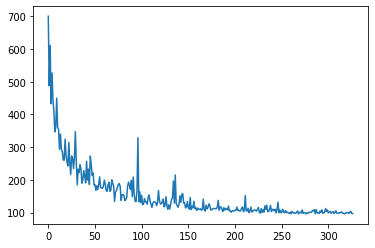

In [24]:
print(min(val_loss))
plt.plot(val_loss)

### Check with entire dataset

In [25]:
model.eval()
with torch.no_grad():
    gt = []
    preds []
    mse_val = 0
    total = 0
    for seq, labels in test_loader:
        total = len(test_loader)
        seq = seq.to(device)
        labels = labels.to(device).view([-1,seq.size(0)])
        y_pred = model(seq).view([-1,seq.size(0)])

        labels = torch.tensor(labels)
        y_pred = torch.tensor(y_pred)

        temp = (seq[:,len(seq)-1,:])
        gt = scaler.inverse_transform(torch.cat([labels,temp], dim =1).detach().cpu().clone().numpy())[0][0]
        pred = scaler.inverse_transform(torch.cat([y_pred,temp], dim =1).detach().cpu().clone().numpy())[0][0]
        loss = loss_function(torch.tensor(pred), torch.tensor(gt)).item()
        gts.append(gt)
        preds.append(pred)              
        mse_val += loss
    

LSTM(
  (lstm): LSTM(42, 120, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=240, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [72]:
final_gt = []
final_pred = []
final_loss = 0 
for i in range(len(x)):
    seq = torch.FloatTensor(x[i].reshape(1,3,-1)).to(device)
    pr = model(seq).reshape(1,-1).to(device)
    label = torch.tensor(y[i]).reshape(1,-1).to(device)
    temp = (seq[:,len(seq)-1,:])

    gt = scaler.inverse_transform(torch.cat([label,temp], dim =1).detach().cpu().clone().numpy())[0][0]
    pred = scaler.inverse_transform(torch.cat([pr,temp], dim =1).detach().cpu().clone().numpy())[0][0]
    loss = loss_function(torch.tensor(pred), torch.tensor(gt)).item()
    final_gt.append(gt)
    final_pred.append(pred)
    final_loss+=loss

In [76]:
feed = pd.DataFrame({'predict': final_pred, 'GT ' : final_gt})
feed

,predict,GT
0,207.971634,189.100000
1,207.971634,189.100000
2,243.495590,251.424419
3,311.934113,302.812199
4,396.233429,384.783406
...,...,...
2861,523.504150,522.989443
2862,518.121948,513.368437
2863,498.472229,502.846843
2864,470.598480,491.954805


In [78]:
max(abs(feed['GT ']-feed['predict']))

1083.0002561250003

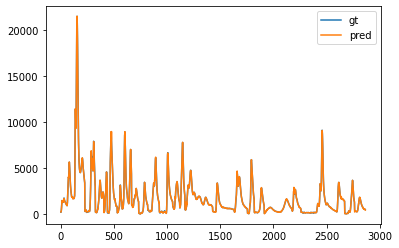

In [81]:
plt.plot(final_gt, label ='gt')
plt.plot(final_pred,label = 'pred')
plt.legend()
plt.show()

In [68]:

rmse = (final_loss/len(final_gt))**0.5
rmse

47.57490063735557